In [1]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random
from random import shuffle
from random import randint

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005
flareperiod = 4096
flarecycles = 10
dayinsec=86400
background = 40
# sat mag u,g,r,i,z,y=14.7,15.7,15.8,15.8,15.3 and 13.9

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty
#from lsst should have got the website! https://smtn-002.lsst.io/

In [5]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [6]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [7]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [8]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds/(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = [np.sin((2*np.pi*(Frequency*0.01)*x)) for x in observations]
    return a

In [9]:
observations = [1,2,3,4,5]
Frequency = 30
exptime = 30
b = [0]*len(observations)
for seconds in range(0, exptime):
    a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds/(3600*24)))) for x in observations] # optical modulation
    b = map(add, a, b)
c = [z/exptime for z in b]
average = c
nonaverage = [np.sin((2*np.pi*(Frequency*0.01)*(x-observations[0]))) for x in observations]
print(average, nonaverage)

([0.0, 0.95105651629515364, -0.58778525229247325, -0.58778525229247336, 0.95105651629515353], [0.0, 0.95105651629515364, -0.58778525229247303, -0.58778525229247336, 0.95105651629515353])


In [10]:
def flaring(B, length, dayinsec=86400,amplitude=1):   
    global flareMag, minutes
    fouriers = np.linspace(0.00001,0.05,(dayinsec/30))
    logF = [np.log(x) for x in fouriers] # start at 30 go to a day in 30 sec increments
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers] #random.gauss(mu,sigma) to change for values from zurita
    # imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,dayinsec, (dayinsec/30))
    minutes = [x for x in seconds]
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT] # what did this even achieve? it helped with normalisation!
    normalised = [x/(np.mean(positive)) for x in positive] # find normalisation
    normalisedmin = minimum/(np.mean(positive))
    normalised = [x - normalisedmin for x in normalised]
    flareMag = [amplitude * x for x in normalised] # normalise to amplitude
#     logmins = [np.log(d) for d in minutes] # for plotting?
#     plt.plot(minutes,flareMag)
#     plt.title('lightcurve')
#     plt.show()
    return flareMag

/home/mj1e16/.local/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


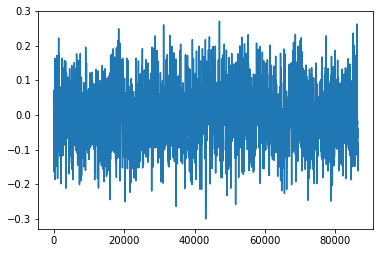

In [11]:
longflare = []
for floop in range(0,5):
    flareone = flaring(-1, flareperiod, amplitude=0.3)
    longflare.append(flareone)
plt.plot(minutes, longflare[1])
#plt.xlim(100,400)
plt.show()

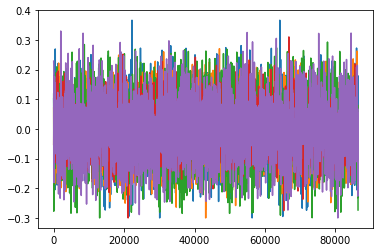

In [12]:
for x in range(0,5):
    plt.plot(minutes, longflare[x])
plt.show()

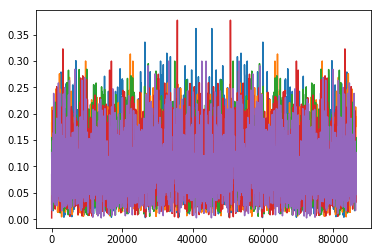

In [13]:
#positivelongflare = [abs(x) for x in longflare]
#positiveflare = [abs(x) for x in flare]

longflare = []
for floop in range(0,5):
    flareone = flaring(-1, flareperiod, amplitude=0.3)
    positiveflare = [abs(x) for x in flareone]
    longflare.append(positiveflare)
    plt.plot(minutes, longflare[floop])
plt.show()

In [14]:
np.mean(longflare)

0.10574348623070215

In [15]:
np.std(longflare)

0.055266031004205511

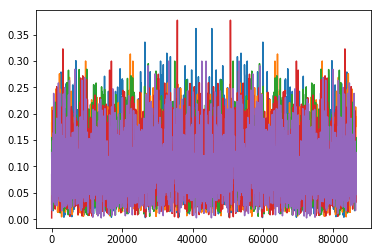

In [16]:
for x in range(0,5):
    plt.plot(minutes, longflare[x])
plt.show()

In [17]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [18]:
# def fullGraph(objectmag,frequency,flareAmp=0.1,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1,background=40): # ramp controls graularity of time
#     global Zmag, dayZ, Zbasic
#     minutesnotindays = np.linspace(0,(175320),175321)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
#     Minutes = [(h/(24*2)) for h in minutesnotindays] # 4 24 24*60
#     #allobsz, uobsz, gobsz, robsz, iobsz, zobsz, yobsz = [], [], [], [], [], [], [] #reset
#     #Z = [allobz, uobsz, gobsz, robsz, iobsz, zobsz, yobsz]
#     Z = [[],[],[],[],[],[],[]]
#     Zbasic = [[],[],[],[],[],[],[]]
    
#     for x in range(1,len(Z)):
#         Z[x] = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, and frequency range
#     for x in range(1,len(Z)):
#         Z[x] = [modulationAmplitude * t for t in Z[x]]
# #     for x in range(0,len(Z)):
    
#     for x in range(1,len(Z)):
#         Zbasic[x] = [t + objectmag[x] for t in Z[x]]
    
#     for x in range(1,len(Z)):
#         for G in range(1, len(Z)):
#             flareMinute = int(round(minutesnotindays[G]*60)%((dayinsec/30)*flarecycles)) # find array number for flaring
#             if flareMinute == ((dayinsec/30)*flarecycles):
#                 flareMinute = ((dayinsec/30)*flarecycles) - 1
#             Z[x][G] = Z[x][G] - longflare[flareMinute]
    
#     Zmag = [[],[],[],[],[],[],[]]
#     for x in range(1,len(Z)):
#         #amplitude = [t-random.gauss(0,magUncertainy(zeroPoints[x],objectmag[x],30,background,FWHMeff[x])) for t in Z[x]] # scale amplitude and add poisson noise         
#         amplitude = [t for t in Z[x]]
#         Zmag[x] = [t + objectmag[x] for t in amplitude]
#     dayZ = [t for t in Minutes]
        

#     plt.plot(dayZ,Zmag[1])
#     plt.xlim(lower,higher)
#     plt.xlabel('time')
#     plt.ylabel('mag')
#     plt.show()


In [105]:
def fullGraph(objectmag,frequency,flareAmp=0.1,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1): # ramp controls graularity of time
    global Zmag, dayZ, Zbasic
    minutesnotindays = np.linspace(0,(175320),175321)# 10 years in 30 minute intervals#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
    Minutes = [(h/(24*2)) for h in minutesnotindays] # 4 24 24*60
    Z = []
    Z = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, and frequency range
    Z = [modulationAmplitude * t for t in Z]
    Zbasic = [t + objectmag for t in Z]
    for G in range(0, len(Z)):
        #flareMinute = int(round((Z[G]*24*60*2)%(dayinsec*10*flarecycles)))
        flareMinute = int(round(minutesnotindays[G]*60)%((dayinsec/30)*flarecycles)) # find array number for flaring
        if flareMinute == ((dayinsec/30)*flarecycles):
            flareMinute = ((dayinsec/30)*flarecycles) - 1
        Z[G] = Z[G] - longflare[flareMinute]

    Zamplitude = [t-random.gauss(0,magUncertainy(zeroPoints[4],objectmag[4],30,background,FWHMeff[4])) for t in Z] # scale amplitude and add poisson noise         
    #Zamplitude = [t for t in Z]
    Zmag = [t + objectmag for t in Zamplitude]
    dayZ = [t for t in Minutes]

    plt.plot(dayZ,Zmag)
    plt.xlim(lower,higher)
    plt.xlabel('time')
    plt.ylabel('mag')
    plt.show()


In [106]:
def lombScargleAuto(frequencyRange,objectmag,lower=0,higher=3500,loopNo=1,numsteps=100000,modulationAmplitude=0.1,Nquist=200): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = [[],[],[],[],[],[]]
    totmperiod = [[],[],[],[],[],[]]
    totpower = [[],[],[],[],[],[]] # reset
    SigLevel = [[],[],[],[],[],[]]
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset

        measuredpower = [] # reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # taken average out # amplitde calculation for observations, and frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]            
        for z in range(1,len(y)):
            for G in range(0, len(y[z])):
                flareMinute = int(round((obs[z][G]*24*60*2)%((dayinsec/30)*flarecycles)))
                y[z][G] = y[z][G] - longflare[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t-random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            #amplitude = [t for t in y[z]]            
            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
                        
            #curve and observations
            plt.plot(dayZ,Zmag)
            plt.plot(dayZ,Zbasic)
            plt.plot(date, mag, 'o')
            plt.xlim(lower,higher)
            plt.xlabel('time (days)')
            plt.ylabel('mag')
            plt.gca().invert_yaxis()
            plt.show()
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            #plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
            phase = [(day.value % (period*2))/(period*2) for day in date]
            idealphase = [(day % (period*2))/(period*2) for day in dayZ]
            
            plt.plot(idealphase,Zmag,'ko',)
            plt.plot(phase, mag, 'yo', markersize=4)
            
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
            
            totperiod[z-1].append(1/(frequencyRange[frange]*0.01))
            totmperiod[z-1].append(np.mean(LSperiod))
            totpower[z-1].append(power.max())
            
            measuredpower.append(power.max())
            maxpower = []
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                periods, power = model.periodogram_auto(nyquist_factor=Nquist)
                maxpower.append(power.max())
                
            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[z-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            print('sig', Significance, 'counter', counter)
            SigLevel[z-1].append(Significance)


In [120]:
def lombScargle(frequencyRange,objectmag,loopNo=1,df=0.001,fmin=0.001,numsteps=100000,modulationAmplitude=0.1,Nquist=200): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = [[],[],[],[],[],[]]
    totmperiod = [[],[],[],[],[],[]]
    totpower = [[],[],[],[],[],[]] # reset
    SigLevel = [[],[],[],[],[],[]]
    freqs = fmin + df * np.arange(numsteps) # for manuel
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]] # scaling
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int(round((obs[z][G]*24*60*2)%((dayinsec/30)*flarecycles)))
                y[z][G] = y[z][G] - longflare[flareMinute] # add flares swapped to second but not changing the name intrtoduces fewer bugs
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag = [t + objectmag[z] for t in amplitude] # add actual mag
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
#             #curve and observations
#             plt.plot(dayZ,Zmag)
#             plt.plot(dayZ,Zbasic)
#             plt.plot(date, mag, 'o')
#             #plt.xlim(lower,higher)
#             plt.xlabel('time (days)')
#             plt.ylabel('mag')
#             plt.gca().invert_yaxis()
#             plt.show()
                     
            model = LombScargleFast().fit(date, mag, error)
            power = model.score_frequency_grid(fmin, df, numsteps)  
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
#             fig, ax = plt.subplots()
#             ax.plot(1./freqs, power)
#             ax.set(xlim=(0, 10), ylim=(0, 1.2),
#                    xlabel='period (days)',
#                    ylabel='Lomb-Scargle Power');
#             plt.show()

#             period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]
#             idealphase = [(day % (period*2))/(period*2) for day in dayZ]
#             plt.plot(idealphase,Zmag,'ko',)
#             plt.plot(phase, mag, 'yo', markersize=4)
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.gca().invert_yaxis()
#             plt.show()
            
#             print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
#             print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
#             print(frequencyRange[frange])
            
#             print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
#             print(frequencyRange[frange], 'z', z)
                  
            totperiod[z-1].append(1/(frequencyRange[frange]*0.01))
            totmperiod[z-1].append(np.mean(LSperiod))
            totpower[z-1].append(power.max())
            
            measuredpower.append(power.max())
            maxpower = []           
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                power = model.score_frequency_grid(fmin, df, numsteps)  
                maxpower.append(power.max())
                

            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            # print('sig', Significance, 'counter', counter)
            SigLevel[z-1].append(Significance)
            

In [22]:
findObservations([(630,)])
averageFlux(obs[0], 1, 30)
longflare = []
for floop in range(0,flarecycles):
    flareone = flaring(-1, flareperiod, amplitude=0.3)
    positiveflare = [abs(x) for x in flareone]
    longflare.extend(positiveflare)

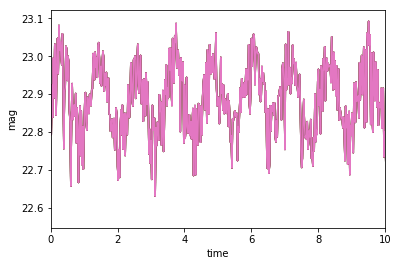

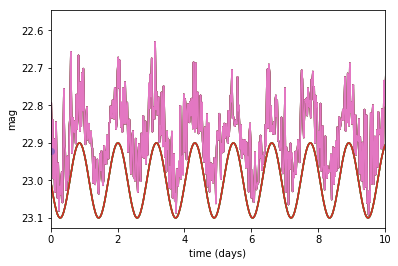

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


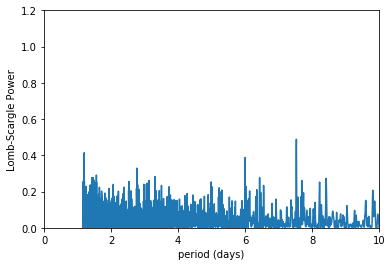

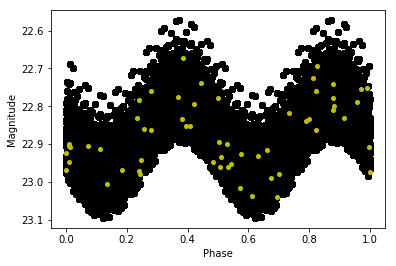

('actualperiod', 1.1494252873563218, 'measured period', 1.1494486016158327) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494486016158327, 1.1506398937931026, 0.48855752493364685)
87
('sig', 1.0, 'counter', 0.0)


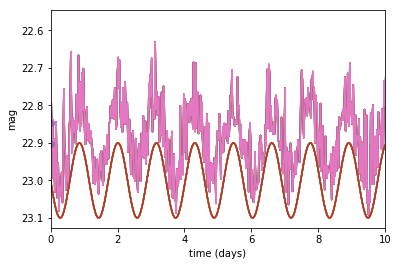

Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


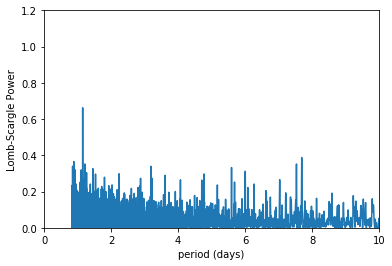

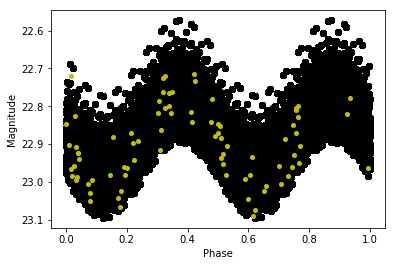

('actualperiod', 1.1494252873563218, 'measured period', 1.1494019088647227) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494019088647227, 0.83410309926829251, 0.66211611926151726)
87
('sig', 1.0, 'counter', 0.0)


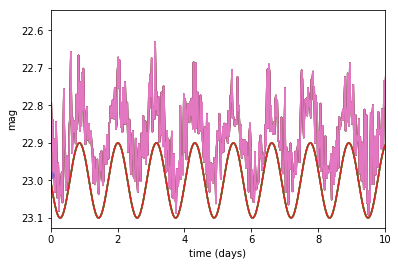

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


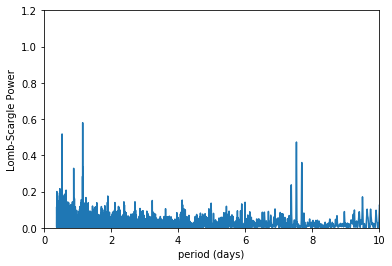

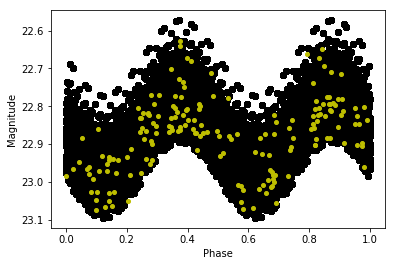

('actualperiod', 1.1494252873563218, 'measured period', 1.149412765543133) ('actualperiod', 1.1494252873563218, 'measured period', 1.149412765543133, 0.37163740518918909, 0.5800243578458919)
87
('sig', 1.0, 'counter', 0.0)


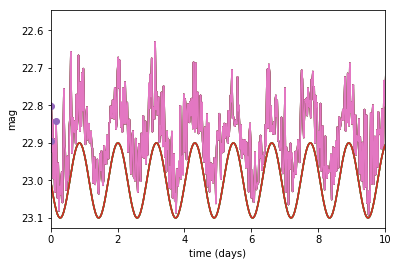

Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


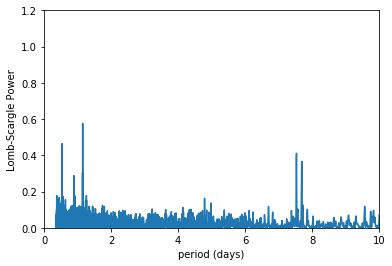

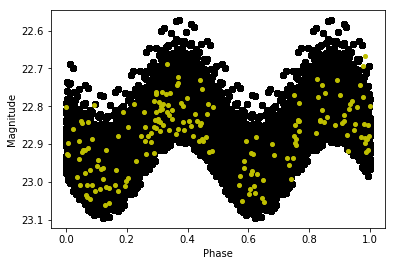

('actualperiod', 1.1494252873563218, 'measured period', 1.1493922271870225) ('actualperiod', 1.1494252873563218, 'measured period', 1.1493922271870225, 0.36590236645161317, 0.5765279980270358)
87
('sig', 1.0, 'counter', 0.0)


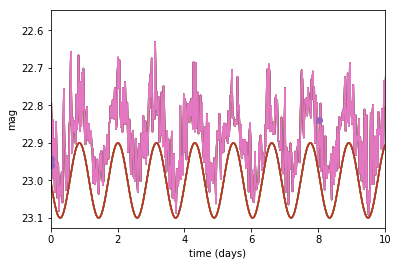

Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


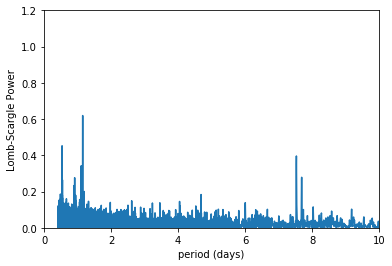

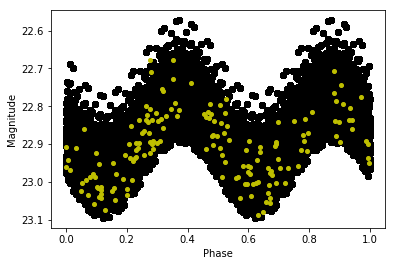

('actualperiod', 1.1494252873563218, 'measured period', 1.1494354467045573) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494354467045573, 0.41372401652694546, 0.61938367431587238)
87
('sig', 1.0, 'counter', 0.0)


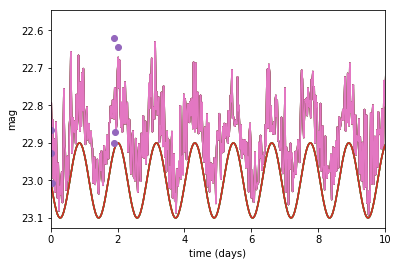

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


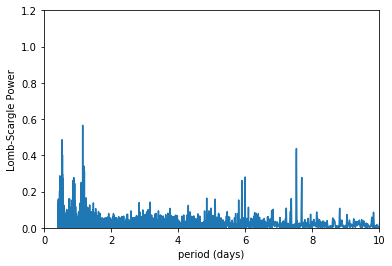

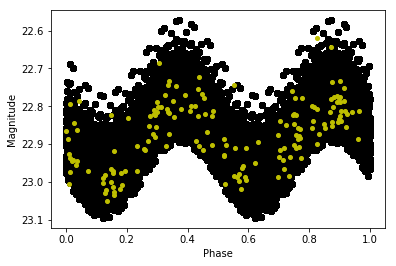

('actualperiod', 1.1494252873563218, 'measured period', 1.1494303376702926) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494303376702926, 0.41015243664670648, 0.5655864102432242)
87
('sig', 1.0, 'counter', 0.0)


In [107]:
# actual frequency = frquency/100
fullGraph([23]*7,87,lower=0,higher=10,ramp=10)
lombScargleAuto([87],([23]*7),Nquist=100,lower=0,higher=10)
 # 40 background corresponing to R band at new moon, could be made more detailed?

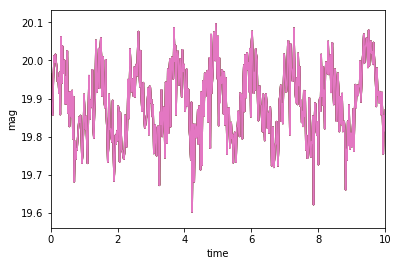

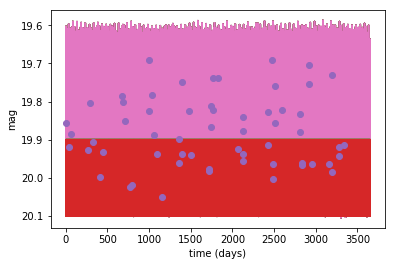

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


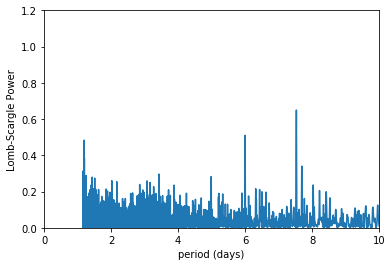

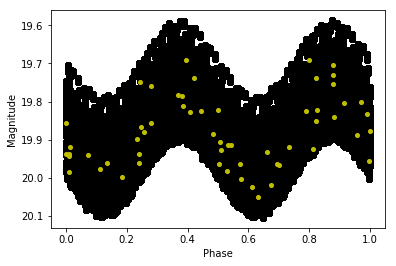

('actualperiod', 1.1494252873563218, 'measured period', 1.14942246942932) ('actualperiod', 1.1494252873563218, 'measured period', 1.14942246942932, 1.1506398937931026, 0.64955681801466703)
87
('sig', 1.0, 'counter', 0.0)


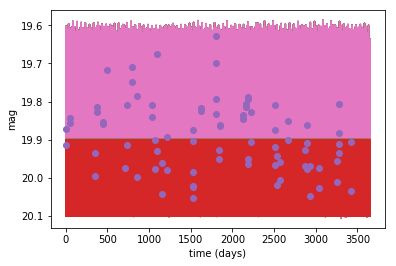

Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


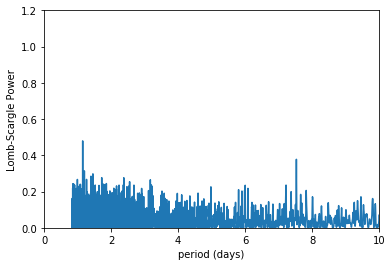

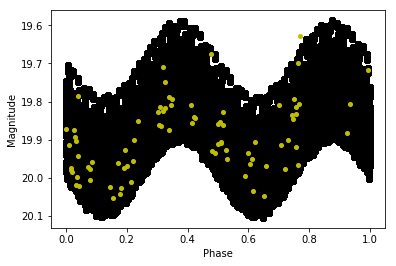

('actualperiod', 1.1494252873563218, 'measured period', 1.1494258608202146) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494258608202146, 0.83410309926829251, 0.47953388079681092)
87
('sig', 1.0, 'counter', 0.0)


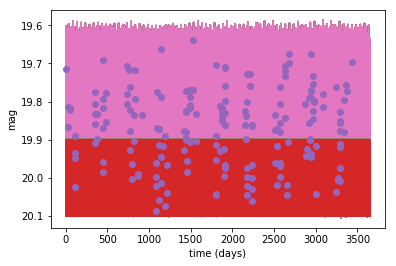

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


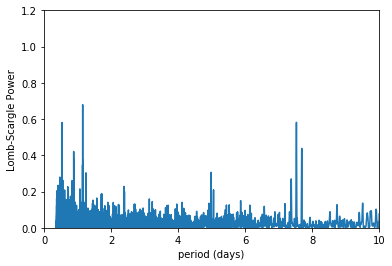

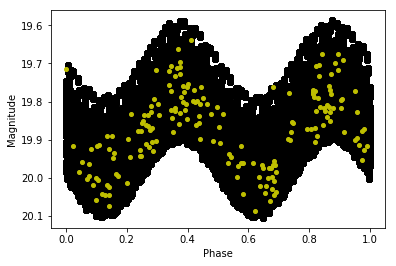

('actualperiod', 1.1494252873563218, 'measured period', 1.1494196833112331) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494196833112331, 0.37163740518918909, 0.67956012165593027)
87
('sig', 1.0, 'counter', 0.0)


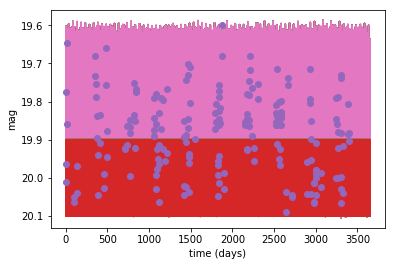

Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


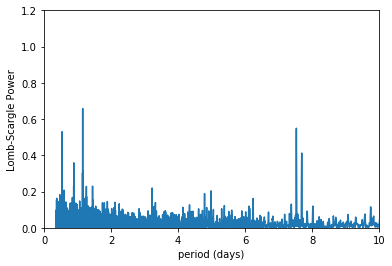

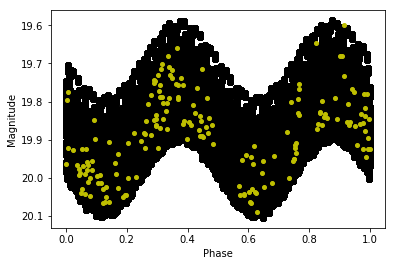

('actualperiod', 1.1494252873563218, 'measured period', 1.1494294984114677) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494294984114677, 0.36590236645161317, 0.65814598079212216)
87
('sig', 1.0, 'counter', 0.0)


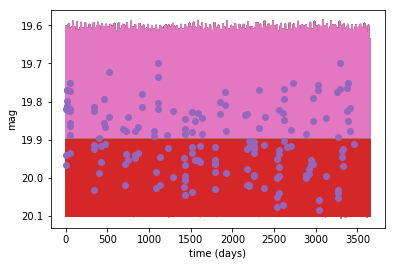

Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


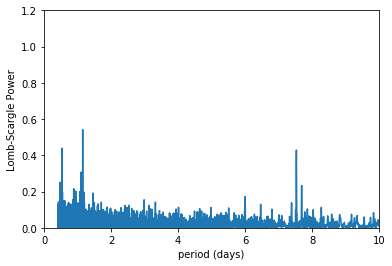

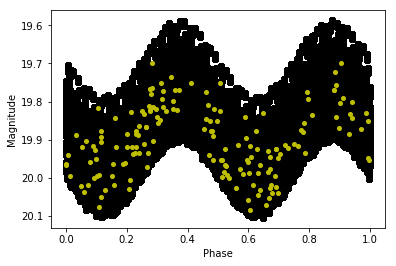

('actualperiod', 1.1494252873563218, 'measured period', 1.1494262680349412) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494262680349412, 0.41372401652694546, 0.54118025335144071)
87
('sig', 1.0, 'counter', 0.0)


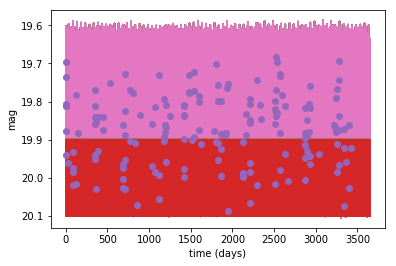

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


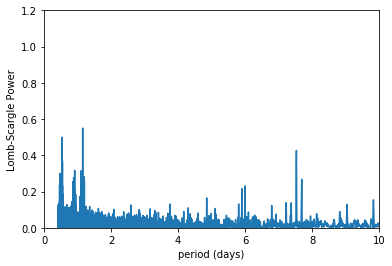

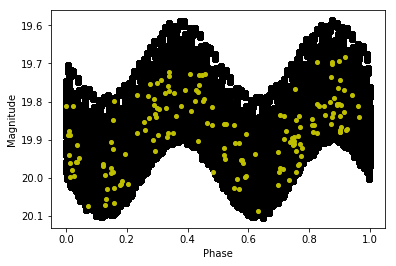

('actualperiod', 1.1494252873563218, 'measured period', 1.14943651009576) ('actualperiod', 1.1494252873563218, 'measured period', 1.14943651009576, 0.41015243664670648, 0.54994788628811531)
87
('sig', 1.0, 'counter', 0.0)


In [225]:
# actual frequency = frquency/100
fullGraph([20]*7,87,lower=0,higher=10,ramp=10)
lombScargleAuto([87],([20]*7),Nquist=100,lower=0,higher=10)
 # 40 background corresponing to R band at new moon, could be made more detailed?

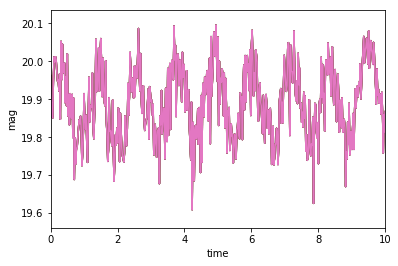

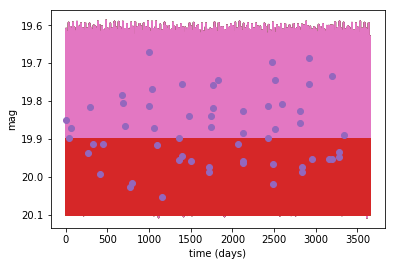

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


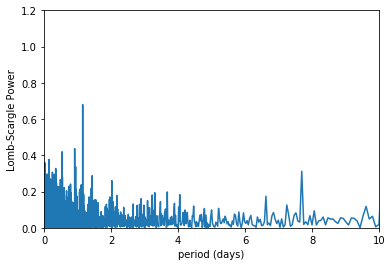

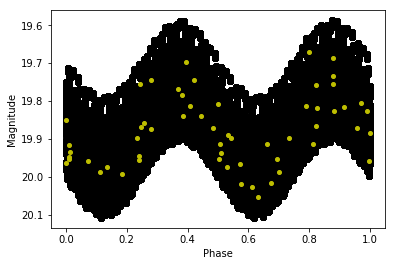

('actualperiod', 1.1494252873563218, 'measured period', 1.149428012521108) ('actualperiod', 1.1494252873563218, 'measured period', 1.149428012521108, 0.41015243664670648, 0.68026870755223234)
87
('sig', 1.0, 'counter', 0.0)


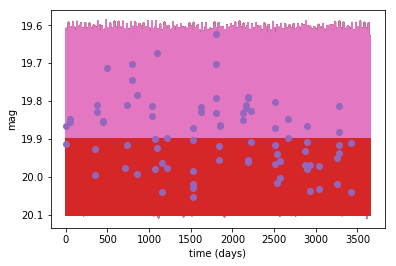

Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


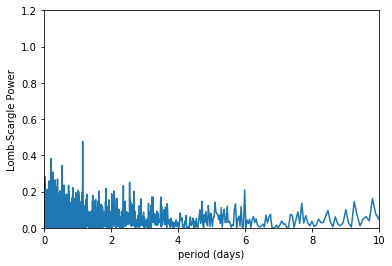

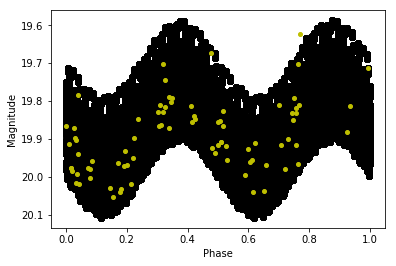

('actualperiod', 1.1494252873563218, 'measured period', 1.1494235428454098) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494235428454098, 0.41015243664670648, 0.47661324839336111)
87
('sig', 1.0, 'counter', 0.0)


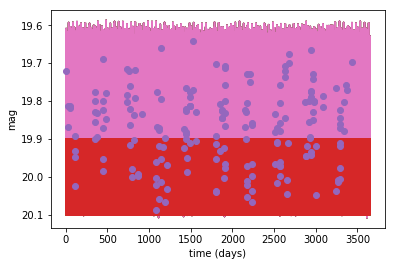

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


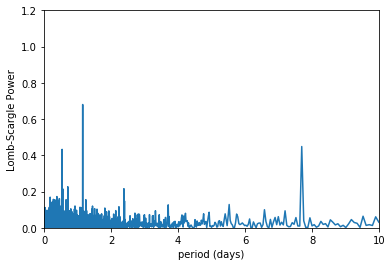

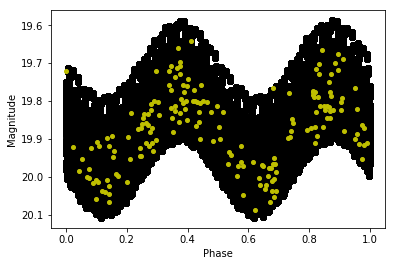

('actualperiod', 1.1494252873563218, 'measured period', 1.149418146022237) ('actualperiod', 1.1494252873563218, 'measured period', 1.149418146022237, 0.41015243664670648, 0.68034589206020946)
87
('sig', 1.0, 'counter', 0.0)


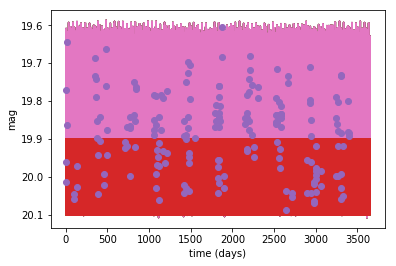

Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


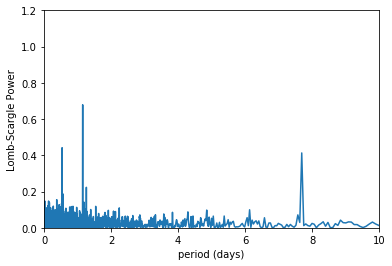

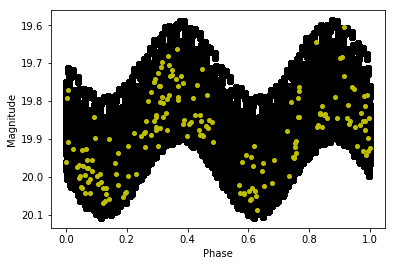

('actualperiod', 1.1494252873563218, 'measured period', 1.1494294984114677) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494294984114677, 0.41015243664670648, 0.67884115896558306)
87
('sig', 1.0, 'counter', 0.0)


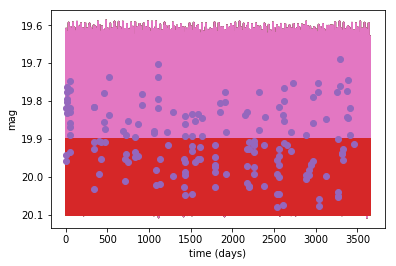

Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


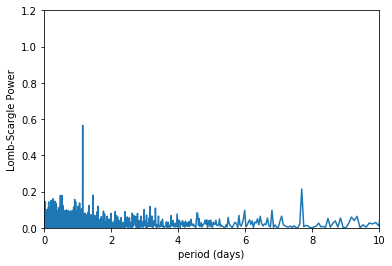

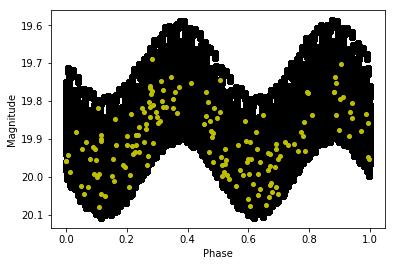

('actualperiod', 1.1494252873563218, 'measured period', 1.1494285626886023) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494285626886023, 0.41015243664670648, 0.56513267222119812)
87
('sig', 1.0, 'counter', 0.0)


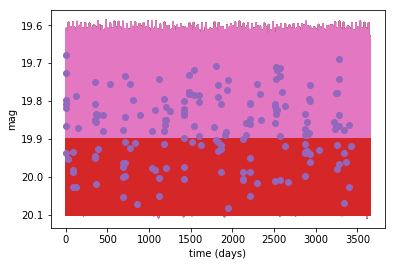

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


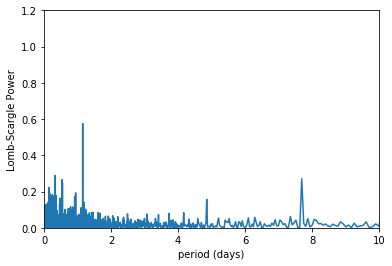

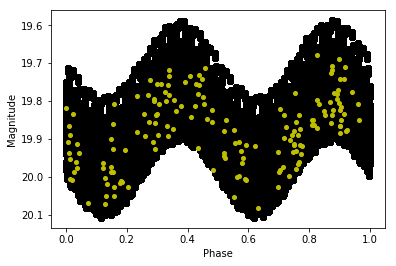

('actualperiod', 1.1494252873563218, 'measured period', 1.1494372816536047) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494372816536047, 0.41015243664670648, 0.57563914301523345)
87
('sig', 1.0, 'counter', 0.0)


In [230]:
# actual frequency = frquency/100
#fullGraph([20]*7,87,lower=0,higher=10,ramp=10)
lombScargle([87],([20]*7),Nquist=100,loopNo=100)
 # 40 background corresponing to R band at new moon, could be made more detailed?

In [88]:
PrangeLoop = [(60./(60.*24.)),(360./(60.*24.)),(1.),(10.)]
PrangeLoop = [(10./(60.*24.)),(60./(60.*24.)),(360./(60.*24.)),(1.),(5.),(10.),(50.)]

FrangeLoop = [(1/x)*100 for x in PrangeLoop]

In [89]:
lombScargle(FrangeLoop,([15]*7),loopNo=100)
fifteentotmperiod = totmperiod
fifteentotperiod = totperiod
fifteentotpower = totpower
fifteenSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [90]:
lombScargle(FrangeLoop,([16]*7),loopNo=100)
sixteentotmperiod = totmperiod
sixteentotperiod = totperiod
sixteentotpower = totpower
sixteenSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [91]:
lombScargle(FrangeLoop,([17]*7),loopNo=100)
seventeentotmperiod = totmperiod
seventeentotperiod = totperiod
seventeentotpower = totpower
seventeenSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [92]:
lombScargle(FrangeLoop,([18]*7),loopNo=100)
eighteentotmperiod = totmperiod
eighteentotperiod = totperiod
eighteentotpower = totpower
eighteenSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [93]:
lombScargle(FrangeLoop,([19]*7),loopNo=100)
nineteentotmperiod = totmperiod
nineteentotperiod = totperiod
nineteentotpower = totpower
nineteenSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [94]:
lombScargle(FrangeLoop,([20]*7),loopNo=100)
twentytotmperiod = totmperiod
twentytotperiod = totperiod
twentytotpower = totpower
twentySigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [95]:
lombScargle(FrangeLoop,([21]*7),loopNo=100)
twentyonetotmperiod = totmperiod
twentyonetotperiod = totperiod
twentyonetotpower = totpower
twentyoneSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [96]:
lombScargle(FrangeLoop,([22]*7),loopNo=100)
twentytwototmperiod = totmperiod
twentytwototperiod = totperiod
twentytwototpower = totpower
twentytwoSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [97]:
lombScargle(FrangeLoop,([23]*7),loopNo=100)
twentythreetotmperiod = totmperiod
twentythreetotperiod = totperiod
twentythreetotpower = totpower
twentythreeSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [98]:
lombScargle(FrangeLoop,([24]*7),loopNo=100)
twentyfourtotmperiod = totmperiod
twentyfourtotperiod = totperiod
twentyfourtotpower = totpower
twentyfourSigLevel = SigLevel

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks

In [36]:
print(twentythreetotmperiod)

[[], [], [0.041666697651332359, 0.25000042529538197, 0.010423376231413067, 10.001687485781003], [], [], []]


In [37]:
print(twentythreetotperiod)

[[], [], [0.041666666666666664, 0.25, 1.0, 10.0], [], [], []]


In [35]:
print(twentythreeSigLevel)

[[], [], [1.0, 1.0, 0.5700000000000001, 1.0], [], [], []]


In [38]:
print(fifteenSigLevel)

[[], [], [1.0, 1.0, 0.65, 1.0], [], [], []]


In [ ]:
for x in range(0,len(FrangeLoop)):
    
     

In [99]:
fullPeriod = []
fullPeriod.append(fifteentotperiod[2])
fullPeriod.append(sixteentotperiod[2])
fullPeriod.append(seventeentotperiod[2])
fullPeriod.append(eighteentotperiod[2])
fullPeriod.append(nineteentotperiod[2])
fullPeriod.append(twentytotperiod[2])
fullPeriod.append(twentyonetotperiod[2])
fullPeriod.append(twentytwototperiod[2])
fullPeriod.append(twentythreetotperiod[2])
fullPeriod.append(twentyfourtotperiod[2])

fullPower = []
fullPower.append(fifteentotpower[2])
fullPower.append(sixteentotpower[2])
fullPower.append(seventeentotpower[2])
fullPower.append(eighteentotpower[2])
fullPower.append(nineteentotpower[2])
fullPower.append(twentytotpower[2])
fullPower.append(twentyonetotpower[2])
fullPower.append(twentytwototpower[2])
fullPower.append(twentythreetotpower[2])
fullPower.append(twentyfourtotpower[2])

fullsignifLevel = []
fullsignifLevel.append(fifteenSigLevel[2])
fullsignifLevel.append(sixteenSigLevel[2])
fullsignifLevel.append(seventeenSigLevel[2])
fullsignifLevel.append(eighteenSigLevel[2])
fullsignifLevel.append(nineteenSigLevel[2])
fullsignifLevel.append(twentySigLevel[2])
fullsignifLevel.append(twentyoneSigLevel[2])
fullsignifLevel.append(twentytwoSigLevel[2])
fullsignifLevel.append(twentythreeSigLevel[2])
fullsignifLevel.append(twentyfourSigLevel[2])

In [65]:
fullsignifLevel

[[1.0, 1.0, 0.65, 1.0],
 [1.0, 1.0, 0.62, 1.0],
 [1.0, 1.0, 0.71, 1.0],
 [1.0, 1.0, 0.61, 1.0],
 [1.0, 1.0, 0.69, 1.0],
 [1.0, 1.0, 0.55, 1.0],
 [1.0, 1.0, 0.65, 1.0],
 [1.0, 1.0, 0.32999999999999996, 1.0],
 [1.0, 1.0, 0.5700000000000001, 1.0],
 [1.0, 1.0, 0.28, 1.0]]

In [100]:
fullMag = [0]*10
for x in range(0,10):
    fullMag[x] = [x+15]*len(FrangeLoop)

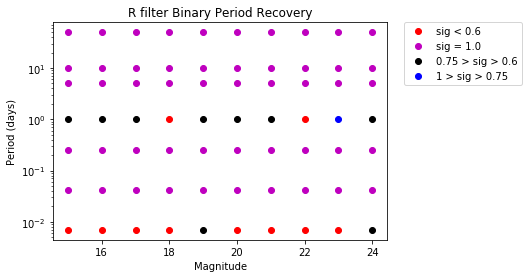

In [102]:
labelcounter1 = 0
labelcounter2 = 0
labelcounter3 = 0
labelcounter4 = 0

for x in range(0,len(fullsignifLevel)):
    for y in range(0,len(fullMag[0])):
        
        Label = 0
        
        if fullsignifLevel[x][y] == 1:
            colour = 'mo'
            if labelcounter1 == 0:
                Label = 'sig = 1.0'
                labelcounter1 = labelcounter1 + 1
        if fullsignifLevel[x][y] < 1 and fullsignifLevel[x][y] > 0.75:
            colour = 'bo'
            if labelcounter2 == 0:
                Label = '1 > sig > 0.75'
                labelcounter2 = labelcounter2 + 1            
        if fullsignifLevel[x][y] < 0.75 and fullsignifLevel[x][y] > 0.6:
            colour = 'ko'
            if labelcounter3 == 0:
                Label = '0.75 > sig > 0.6'
                labelcounter3 = labelcounter3 + 1            
        if fullsignifLevel[x][y] < 0.6:
            colour = 'ro'
            if labelcounter4 == 0:
                Label = 'sig < 0.6'
                labelcounter4 = labelcounter4 + 1
        
        if Label!=0:    
            plt.plot(fullMag[x][y],fullPeriod[x][y],colour,label=Label)
        else:
            plt.plot(fullMag[x][y],fullPeriod[x][y],colour)
plt.xlabel('Magnitude')
plt.ylabel('Period (days)')
plt.yscale('log')
plt.title('R filter Binary Period Recovery')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [63]:
len(fullsignifLevel)

10

In [67]:
Label ='one'
if Label!=1:
    print('yay')

yay


In [108]:
PrangeLoop = [(10./(60.*24.)),(60./(60.*24.)),(360./(60.*24.)),(1.),(5.),(10.),(50.)]
FrangeLoop = [(1/x)*100 for x in PrangeLoop]

In [ ]:
fullmeasuredPeriod = [[],[],[],[],[],[]]
fullPeriod = [[],[],[],[],[],[]]
fullPower = [[],[],[],[],[],[]]
fullSigLevel = [[],[],[],[],[],[]]
fullMag = [[],[],[],[],[],[]]
MagRange = [17,18,19,20,21,22,23,24]
for h in range(0,len(MagRange)):
    lombScargle(FrangeLoop,([MagRange[h]]*7),loopNo=100)
    for x in range(0,len(fullmeasuredPeriod)):
        fullmeasuredPeriod[x].append(totmperiod[x])
        fullPeriod[x].append(totperiod[x])
        fullPower[x].append(totpower[x])
        fullSigLevel[x].append(SigLevel[x])
        fullMag[x].append([MagRange[h]]*len(FrangeLoop))



Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate pea

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10


Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10

Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


In [118]:
print(fullmeasuredPeriod)

[[[], [], [], [], [], [], [], [], [], []], [[], [], [], [], [], [], [], [], [], []], [[0.015519782128808857, 0.041666693611094298, 0.24999998894955511, 1.0000289154479927, 5.0006589664881957, 10.001280109485016, 1.017513030333663], [0.015519782128808857, 0.041666693611094298, 0.24999998894955511, 0.0437048855599231, 5.0006589664881957, 10.001280109485016, 1.017513030333663], [0.015519782128808857, 0.041666694621153744, 0.24999998894955511, 1.0000289154479927, 5.0006589664881957, 10.001280109485016, 1.017513030333663], [0.015519782128808857, 0.041666693611094298, 0.24999998894955511, 0.043704884448629515, 5.0006589664881957, 10.001221915580308, 1.0175136326838645], [0.01551978226894175, 0.041666695631213231, 0.25000002531164917, 1.0000283336212132, 5.0006589664881957, 10.001221915580308, 1.017513030333663], [0.01551978226894175, 0.041666694621153744, 0.24999998894955511, 1.0000289154479927, 5.0006589664881957, 10.001338304066953, 1.017513030333663], [0.015519782549207543, 0.041666692601

In [114]:
labelcounter1 = 0
labelcounter2 = 0
labelcounter3 = 0
labelcounter4 = 0

for x in range(0,len(fullSigLevel)):
    for y in range(0,len(MagRange)):
        for z in range(0,len(FrangeLoop)):
            Label = 0

            if fullmeasuredPeriod[x][y][z] < fullPeriod+(fullPeriod*0.1) and fullmeasuredPeriod[x][y][z] > fullPeriod-(fullPeriod*0.1):
                if fullsignifLevel[x][y][z] == 1:
                    colour = 'co'
                    if labelcounter1 == 0:
                        Label = 'sig = 1.0'
                        labelcounter1 = labelcounter1 + 1
                if fullsignifLevel[x][y][z] < 1 and fullsignifLevel[x][y][z] > 0.75:
                    colour = 'mo'
                    if labelcounter2 == 0:
                        Label = '1 > sig > 0.75'
                        labelcounter2 = labelcounter2 + 1            
                if fullsignifLevel[x][y][z] < 0.75 and fullsignifLevel[x][y][z] > 0.6:
                    colour = 'bo'
                    if labelcounter3 == 0:
                        Label = '0.75 > sig > 0.6'
                        labelcounter3 = labelcounter3 + 1            
                if fullsignifLevel[x][y][z] < 0.6:
                    colour = 'ko'
                    if labelcounter4 == 0:
                        Label = 'sig < 0.6'
                        labelcounter4 = labelcounter4 + 1

                if Label!=0:    
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour,label=Label)
                else:
                    plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],colour)
            else:
                plt.plot(fullMag[x][y][z],fullPeriod[x][y][z],'ro',label='Wrong Period')
plt.xlabel('Magnitude')
plt.ylabel('Period (days)')
plt.yscale('log')
plt.title('R filter Binary Period Recovery')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

IndexError: list index out of range

In [119]:
print(totpower)

[[], [], [0.13839184350322192, 0.358037064352898, 0.34955025541577212, 0.122973990635267, 0.47107317504511759, 0.40134950558541083, 0.31510491725413758], [], [], []]
